In [1]:
import numpy as np
from numba import njit, uint64, float64
from numba.typed import Dict
from hftbacktest import BUY, SELL, GTX, LIMIT
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest, Recorder
from hftbacktest.stats import LinearAssetRecord

# beerusdt = np.load('hft_db/beerusdt_20240601.npz')['data']
# beerusdt_latency = 'latency/beerusdt_20240601.npz'
# binance = np.load('hft_db/binance_20240601.npz')['data']
# binance_latency = 'latency/binance_20240601.npz'


In [35]:

@njit
def gridtrading(hbt, recorder):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    grid_num = 10
    max_position = 100
    grid_interval = tick_size * 10
    half_spread = tick_size * 5

    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:
        # Clears cancelled, filled or expired orders.
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask

        mid_price = (best_bid + best_ask) / 2.0

        order_qty = 0.1 # np.round(notional_order_qty / mid_price / hbt.depth(asset_no).lot_size) * hbt.depth(asset_no).lot_size

        # Aligns the prices to the grid.
        bid_price = np.floor((mid_price - half_spread) / grid_interval) * grid_interval
        ask_price = np.ceil((mid_price + half_spread) / grid_interval) * grid_interval

        #--------------------------------------------------------
        # Updates quotes.

        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price): # position * mid_price < max_notional_position
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)

                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price

                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price): # position * mid_price > -max_notional_position
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)

                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval

        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)

        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)

        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True
 

In [29]:

asset_beer = (
    BacktestAsset()
        .data(beerusdt)
        .intp_order_latency(beerusdt_latency)
        .linear_asset(1.0)
        # .constant_latency(10_000_000, 10_000_000)
        .risk_adverse_queue_model()
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.00015)
        .tick_size(0.00001)
        .lot_size(1)
        .last_trades_capacity(2)
        .roi_lb(0.15)
        .roi_ub(0.19)
)



In [30]:
hbt = ROIVectorMarketDepthBacktest([asset_beer])
# hbt = ROIVectorMarketDepthBacktest([asset_binance])
recorder = Recorder(1, 5_000_000)
gridtrading(hbt, recorder.recorder)
_ = hbt.close()

In [31]:
stats = LinearAssetRecord(recorder.get(0)).stats(book_size=10_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-05-31 23:59:50,2024-06-01 23:59:50,NaN,NaN,NaN,0.000009,22820.0,0.039798,NaN,NaN,1.209879


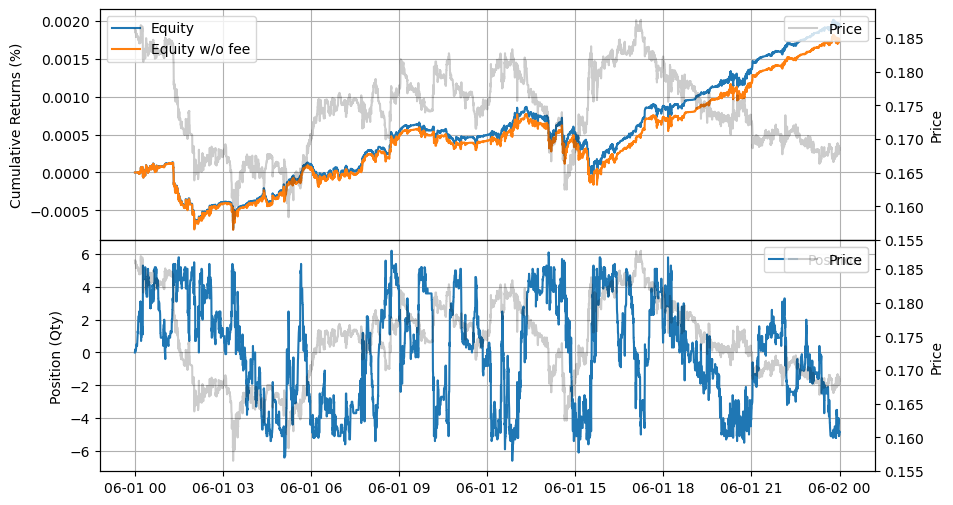

In [32]:
stats.plot()

In [36]:
asset_binance = (
    BacktestAsset()
    .data([
        "hft_db/btcusdt_20240802.npz",
        "hft_db/btcusdt_20240803.npz",
        "hft_db/btcusdt_20240804.npz"
    ])
    .intp_order_latency(
        [
            "latency/btcusdt_20240802.npz",
            "latency/btcusdt_20240803.npz",
            "latency/btcusdt_20240804.npz",
        ]
    )
    .linear_asset(1.0)
    # .constant_latency(10_000_000, 10_000_000)
    .power_prob_queue_model(2.0)
    .no_partial_fill_exchange()
    # .trading_value_fee_model(-0.00005, 0.00015)
    .trading_value_fee_model(-0.00004, 0.00023)
    # .trading_value_fee_model(0.00011, 0.00023)
    .tick_size(0.001)
    .lot_size(0.1)
    # .last_trades_capacity(10000)
    .roi_lb(55000)
    .roi_ub(66500)
)

hbt = ROIVectorMarketDepthBacktest([asset_binance])
recorder = Recorder(1, 5_000_000)
gridtrading(hbt, recorder.recorder)
_ = hbt.close()
record_data = recorder.get(0)
print(f'Length: {len(record_data)}')
record_data = record_data[~np.isnan(record_data['price'])]
print(f'After dropping NaN values: {len(record_data)}')
stats = LinearAssetRecord(record_data).stats(book_size=10_000)
stats.summary()


Length: 2592022
After dropping NaN values: 2591998


start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-08-02 00:00:00,2024-08-04 23:59:50,-5.663755,-7.669327,-15.334067,33.35034,1.1624e6,716105.323619,-0.459787,-0.000007,7.2995e6


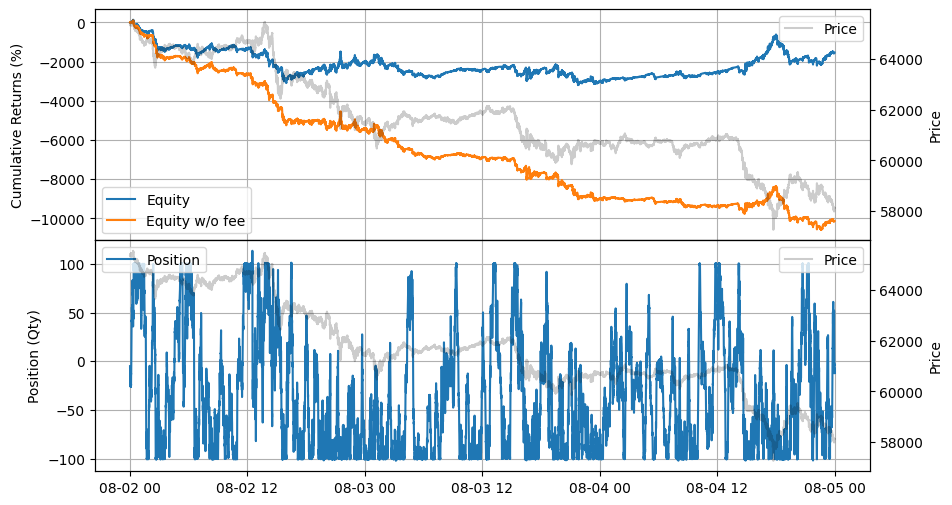

In [37]:
stats.plot()
